<a href="https://colab.research.google.com/github/Kartikay45/Journal-Paper-IJSECS--Malaysia/blob/main/MINOR_PROJECT_MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 9.4 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-10-f2598832f0ed>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'].fillna(method='ffill', inplace=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss real: 0.6941] [D loss fake: 0.6936] [G loss: 0.6936]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
10 [D loss real: 0.6939] [D loss fake: 0.6939] [G loss: 0.6939]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
20 [D loss real: 0.6940] [D loss fake: 0.6940] [G loss: 0.6940]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

<ipython-input-10-f2598832f0ed>:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(data.index[time_steps:][valid_anomalies], data['Close'][time_steps:][valid_anomalies],


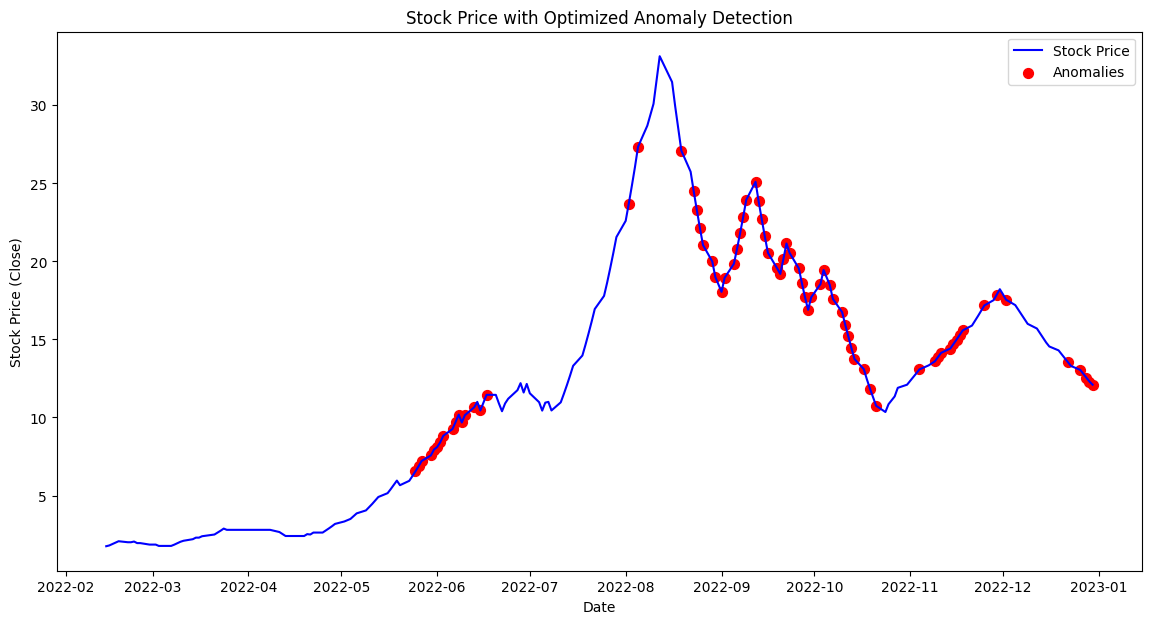

In [ ]:
# GAN-ISOLATION FOREST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Flatten, Reshape, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import yfinance as yf


data = yf.download("SADHNA.BO", start="2022-01-01", end="2023-01-01")
data['Close'].fillna(method='ffill', inplace=True)


data['MA20'] = data['Close'].rolling(window=20).mean()
data = data.dropna()


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', 'MA20']])


def wavelet_transform(data, wavelet='db4', level=3):
    coeffs = [pywt.wavedec(data[:, i], wavelet, level=level) for i in range(data.shape[1])]
    return np.array([np.concatenate(coeff) for coeff in coeffs])

data_wavelet = wavelet_transform(data_scaled)


def create_wavelet_sequences(data_wavelet, time_steps=10):
    sequences, labels = [], []
    for i in range(len(data_wavelet[0]) - time_steps):
        seq = data_wavelet[:, i:i + time_steps]
        if seq.shape[1] == time_steps:
            sequences.append(seq.T)
            labels.append(data_wavelet[:, i + time_steps])
    return np.array(sequences), np.array(labels)


time_steps = 10
X, y = create_wavelet_sequences(data_wavelet, time_steps=time_steps)


def build_generator(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(256, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(np.prod(input_shape), activation='linear'))
    model.add(Reshape(input_shape))
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse')
    return model


def build_discriminator(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')
    return model


def build_gan(generator, discriminator, input_shape):
    discriminator.trainable = False
    gan_input = Input(shape=input_shape)
    generated_seq = generator(gan_input)
    gan_output = discriminator(generated_seq)
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(learning_rate=0.0002), loss='binary_crossentropy')
    return gan


def train_gan(generator, discriminator, gan, X_train, epochs=100, batch_size=64):
    half_batch = batch_size // 2
    for epoch in range(epochs):

        idx_real = np.random.randint(0, X_train.shape[0], half_batch)
        real_seqs = X_train[idx_real]


        noise = np.random.normal(0, 1, (half_batch, X_train.shape[1], X_train.shape[2]))
        generated_seqs = generator.predict(noise)


        d_loss_real = discriminator.train_on_batch(real_seqs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(generated_seqs, np.zeros((half_batch, 1)))


        if isinstance(d_loss_real, list):
            d_loss_real = d_loss_real[0]
        if isinstance(d_loss_fake, list):
            d_loss_fake = d_loss_fake[0]


        noise = np.random.normal(0, 1, (batch_size, X_train.shape[1], X_train.shape[2]))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)


        if isinstance(g_loss, list):
            g_loss = g_loss[0]


        if epoch % 10 == 0:
            print(f"{epoch} [D loss real: {d_loss_real:.4f}] [D loss fake: {d_loss_fake:.4f}] [G loss: {g_loss:.4f}]")


input_shape = (time_steps, X.shape[2])
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)
gan = build_gan(generator, discriminator, input_shape)


train_gan(generator, discriminator, gan, X, epochs=100, batch_size=64)


def detect_anomalies(generator, data, time_steps):
    generated_seqs = generator.predict(data)
    reconstruction_error = np.mean(np.abs(data - generated_seqs), axis=1)
    return reconstruction_error


reconstruction_error = detect_anomalies(generator, X, time_steps)


threshold_max = np.max(reconstruction_error)
threshold_std = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)


X_flattened = X.reshape(X.shape[0], -1)

isolation_forest = IsolationForest(contamination=0.08)
isolation_forest.fit(X_flattened)


if_scores = isolation_forest.decision_function(X_flattened)

combined_scores = reconstruction_error.mean() + if_scores

threshold_combined = np.quantile(combined_scores, 0.60)

anomalies = np.where(combined_scores > threshold_combined)[0]

max_index = len(data.index[time_steps:])
valid_anomalies = anomalies[anomalies < max_index]

plt.figure(figsize=(14, 7))
plt.plot(data.index[time_steps:], data['Close'][time_steps:], label='Stock Price', color='blue')

if len(valid_anomalies) > 0:
    plt.scatter(data.index[time_steps:][valid_anomalies], data['Close'][time_steps:][valid_anomalies],
                color='red', label='Anomalies', s=50)

plt.title('Stock Price with Optimized Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.show()





Precision: 0.2
Recall: 1.0
Accuracy: 0.680672268907563
F1 Score: 0.33333333333333337
Specificity: 0.6529680365296804


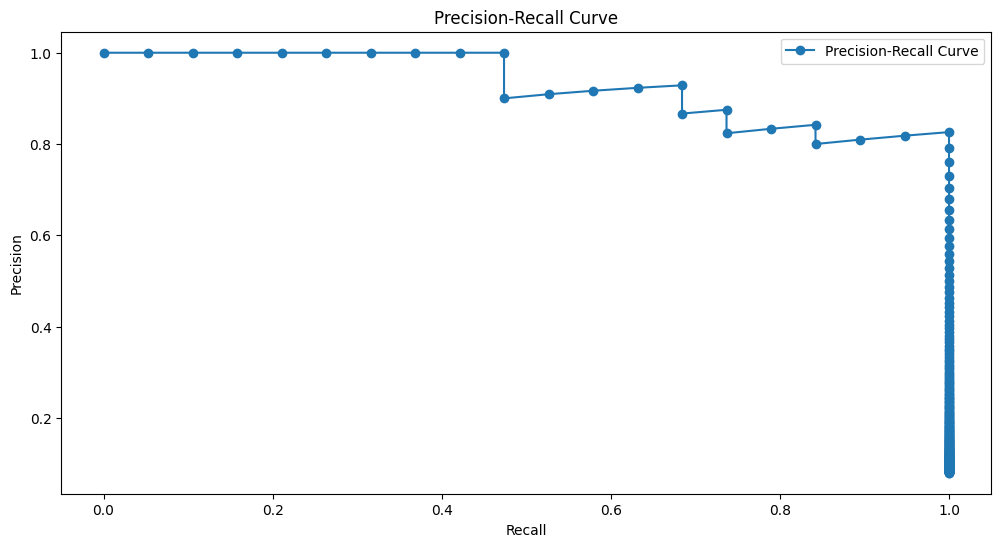

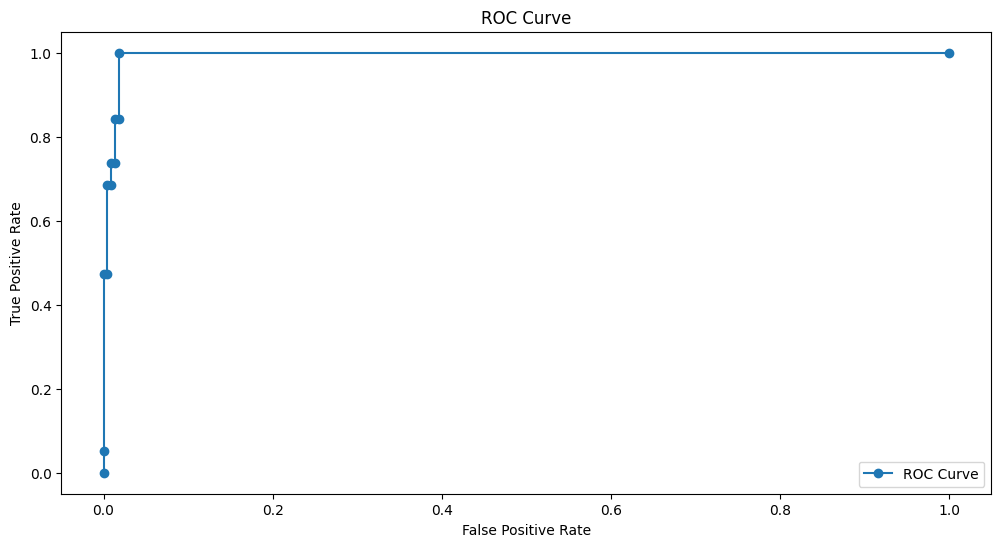

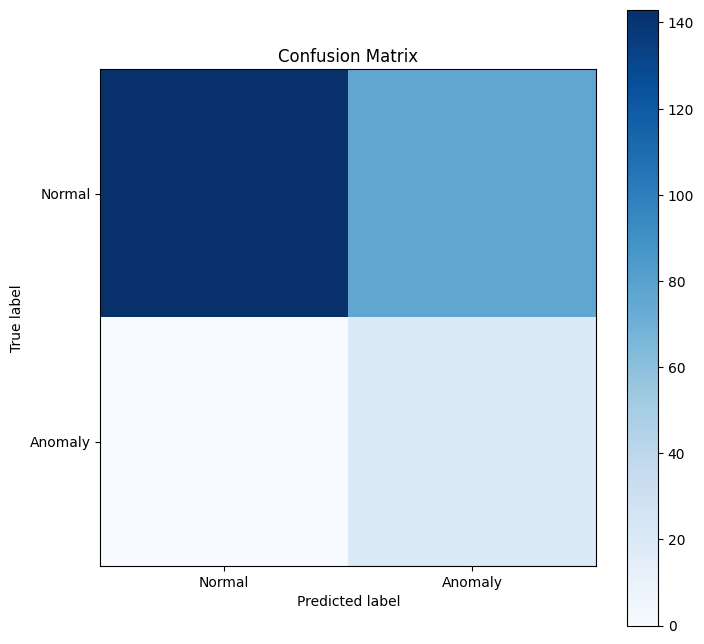

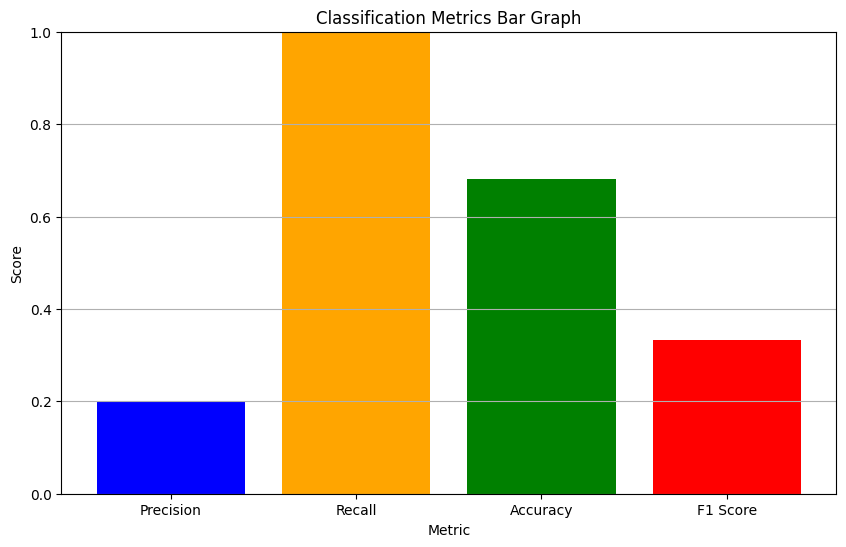

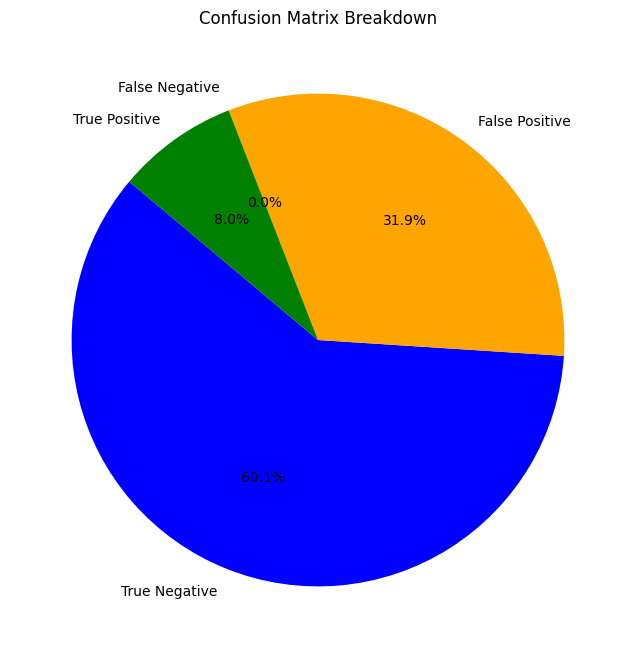

In [ ]:
## for GAN-Iforest
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

threshold_max = np.max(reconstruction_error)
threshold_std = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)


X_flattened = X.reshape(X.shape[0], -1)
isolation_forest = IsolationForest(contamination=0.08)
isolation_forest.fit(X_flattened)
if_scores = isolation_forest.decision_function(X_flattened)


combined_scores = reconstruction_error.mean(axis=1) + if_scores
threshold_combined = np.quantile(combined_scores, 0.60)  # Adjusted percentile


y_true = (if_scores < 0).astype(int)
y_pred = (combined_scores > threshold_combined).astype(int)


precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)


conf_matrix = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")

# Plot metrics
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, combined_scores)
plt.figure(figsize=(12, 6))
plt.plot(recall_vals, precision_vals, marker='o', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, combined_scores)
plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, marker='o', label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['Normal', 'Anomaly']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Bar Graph for Classification Metrics
metrics = [precision, recall, accuracy, f1]
metrics_names = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
plt.figure(figsize=(10, 6))
plt.bar(metrics_names, metrics, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Classification Metrics Bar Graph')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Pie Chart for Confusion Matrix
plt.figure(figsize=(8, 8))
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
sizes = [tn, fp, fn, tp]
colors = ['blue', 'orange', 'red', 'green']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Confusion Matrix Breakdown')
plt.show()

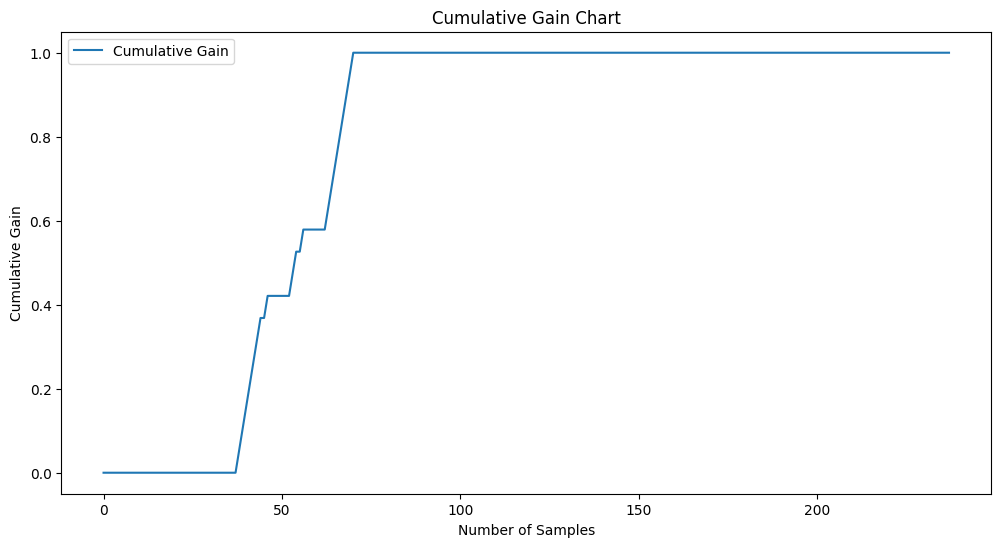

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# Assuming y_pred contains probabilities
sorted_indices = np.argsort(y_pred)[::-1]
cumulative_gain = np.cumsum(y_true[sorted_indices]) / np.sum(y_true)
plt.figure(figsize=(12, 6))
plt.plot(cumulative_gain, label='Cumulative Gain')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain Chart')
plt.legend()
plt.show()


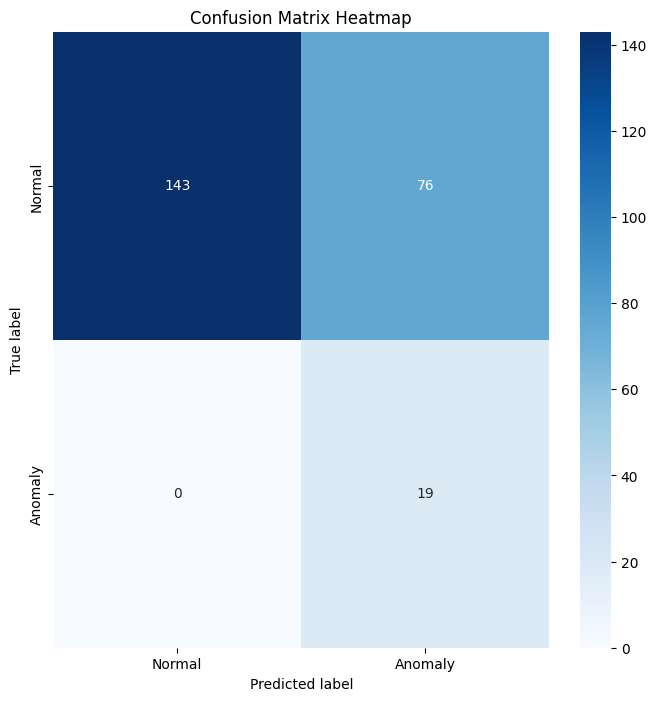

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix Heatmap')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


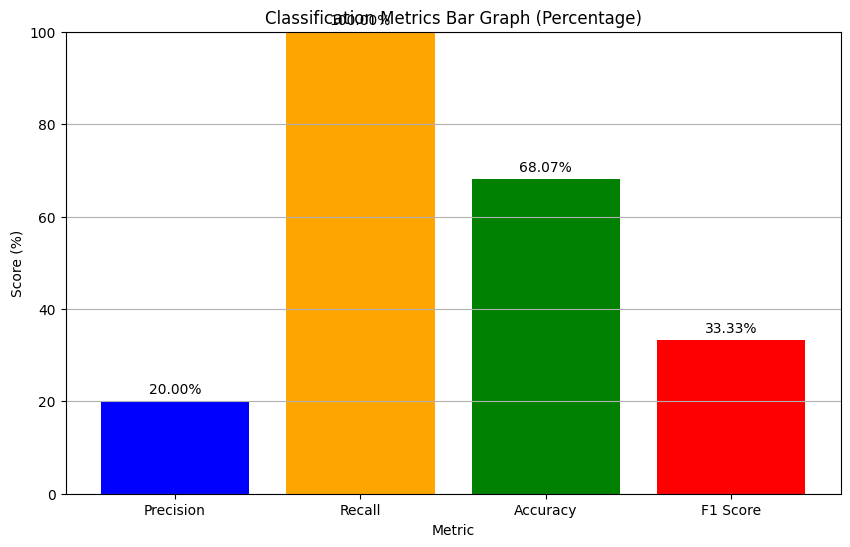

In [ ]:
import matplotlib.pyplot as plt


metrics = [precision * 100, recall * 100, accuracy * 100, f1 * 100]
metrics_names = ['Precision', 'Recall', 'Accuracy', 'F1 Score']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metric')
plt.ylabel('Score (%)')
plt.title('Classification Metrics Bar Graph (Percentage)')
plt.ylim(0, 100)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

plt.grid(axis='y')
plt.show()



[*********************100%***********************]  1 of 1 completed


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - loss: 0.1820 - val_loss: 7.3897e-04
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.1405 - val_loss: 0.0037
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1024 - val_loss: 0.0122
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0519 - val_loss: 0.0197
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0415 - val_loss: 0.0034
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0356 - val_loss: 8.3734e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0212 - val_loss: 4.2084e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0249 - val_loss: 6.2036e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0167 - val_loss: 0.0012
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0175 - val_loss: 7.3167e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0145 - val_loss: 6.6450e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0

<ipython-input-4-cfba716d5a69>:73: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(data.index[time_steps:][anomalies], data['Close'][time_steps:][anomalies], color='red', label='Anomalies')


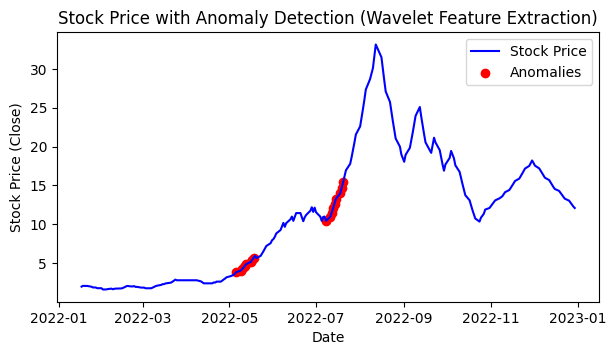

In [ ]:
##GAN-AE

import pywt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


import yfinance as yf
data = yf.download("SADHNA.BO", start="2022-01-01", end="2023-01-01")
data = data[['Close']]


scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


def wavelet_transform(data, wavelet='db4', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    return np.concatenate(coeffs, axis=1)


data_wavelet = wavelet_transform(data_scaled.T)


def create_wavelet_sequences(data_wavelet, time_steps=10, feature_size=15):
    sequences, labels = [], []
    for i in range(len(data_wavelet[0]) - time_steps):
        seq = data_wavelet[:, i:i + time_steps]
        if seq.shape[1] == time_steps:
            sequences.append(seq.T)
            labels.append(data_wavelet[:, i + time_steps])
    return np.array(sequences), np.array(labels)


time_steps = 10
feature_size = 15
X, y = create_wavelet_sequences(data_wavelet, time_steps, feature_size)


from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input

def build_lstm_ae(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, activation='relu')(inputs)
    encoded = RepeatVector(input_shape[0])(encoded)

    decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_shape[1]))(decoded)

    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


input_shape = (X.shape[1], X.shape[2])


lstm_ae = build_lstm_ae(input_shape)
lstm_ae.fit(X, X, epochs=50, batch_size=32, validation_split=0.1)


reconstruction = lstm_ae.predict(X)
reconstruction_error = np.mean(np.abs(reconstruction - X), axis=1)
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
anomalies = np.where(reconstruction_error > threshold)[0]


plt.figure(figsize=(7, 3.5))
plt.plot(data.index[time_steps:], data['Close'][time_steps:], label='Stock Price', color='blue')
plt.scatter(data.index[time_steps:][anomalies], data['Close'][time_steps:][anomalies], color='red', label='Anomalies')
plt.title('Stock Price with Anomaly Detection (Wavelet Feature Extraction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (Close)')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-2-6f60baebdd9f>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'].fillna(method='ffill', inplace=True)


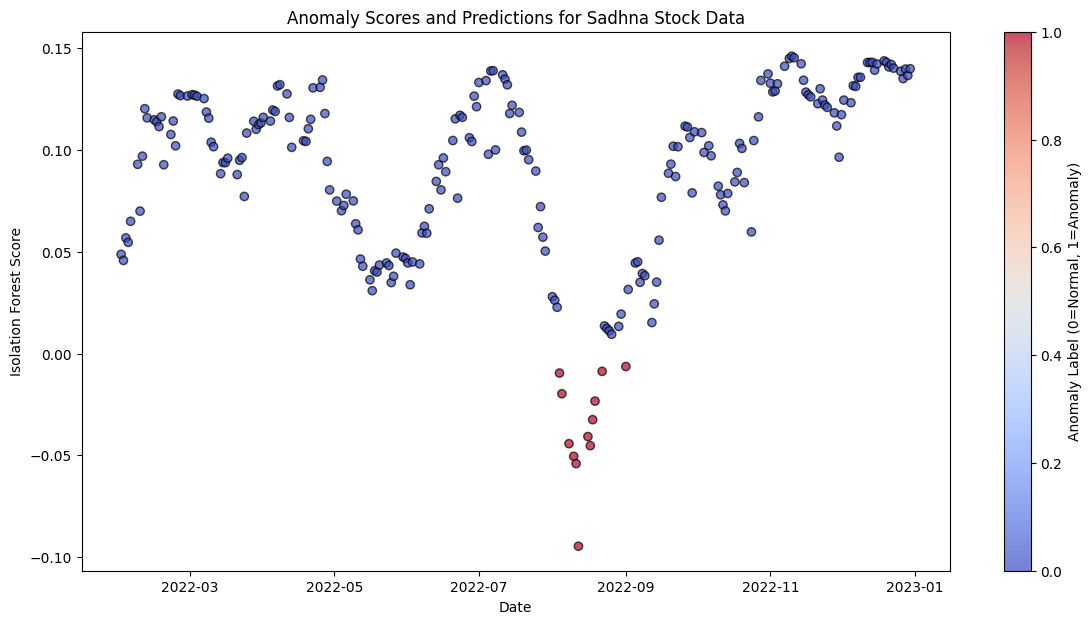

In [ ]:
### validation of isolation forest


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf


data = yf.download("SADHNA.BO", start="2022-01-01", end="2023-01-01")
data['Close'].fillna(method='ffill', inplace=True)


data['MA20'] = data['Close'].rolling(window=20).mean()
data = data.dropna()

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['Close', 'MA20']])


isolation_forest = IsolationForest(contamination=0.05)  # Adjust contamination as needed
isolation_forest.fit(data_scaled)


if_scores = isolation_forest.decision_function(data_scaled)
y_pred = isolation_forest.predict(data_scaled)
y_pred = (y_pred == -1).astype(int)


plt.figure(figsize=(14, 7))
plt.scatter(data.index, if_scores, c=y_pred, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Isolation Forest Score')
plt.title('Anomaly Scores and Predictions for Sadhna Stock Data')
plt.colorbar(label='Anomaly Label (0=Normal, 1=Anomaly)')
plt.show()


In [ ]:
print(if_scores)

[ 2.44107198e-01  2.41053206e-01  2.29633840e-01  1.96032785e-01
  1.58566502e-01  1.14008951e-01  5.72003588e-02  1.92395889e-02
  4.69407782e-03  2.16363914e-04 -8.73224813e-03 -2.20188953e-02
 -6.08839185e-02 -7.16136992e-02 -6.18583395e-02 -5.83487457e-02
 -5.69875971e-02 -5.97468983e-02 -5.15902582e-02 -4.88147705e-02
 -7.47053305e-02 -6.64281564e-02 -3.00750223e-02 -1.80617296e-02
  9.82179807e-03 -9.00618203e-03 -5.19273395e-03 -2.05168018e-02
 -2.97677404e-02 -1.13801917e-02  1.19457401e-02  3.45220304e-02
  9.62119772e-02  1.77353361e-01  3.12890217e-01  3.14892174e-01
  3.13906468e-01  3.18983870e-01  3.14546441e-01  3.10355902e-01
  3.09805428e-01  3.07060244e-01  2.93959791e-01  2.86821439e-01
  2.74578318e-01  2.67666068e-01  2.61220956e-01  2.36942028e-01
  2.12612141e-01  2.19866034e-01  2.26718131e-01  2.23164556e-01
  2.18110233e-01  2.06221817e-01  2.42894374e-01  2.44001765e-01
  2.57967349e-01  2.59272483e-01  2.68089140e-01  2.83469886e-01
  2.77527052e-01  2.81912

In [ ]:
print(y_pred)

[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0
 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1
 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0]


In [ ]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import (precision_score, recall_score, accuracy_score, f1_score,
                             confusion_matrix, roc_curve, precision_recall_curve)